In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

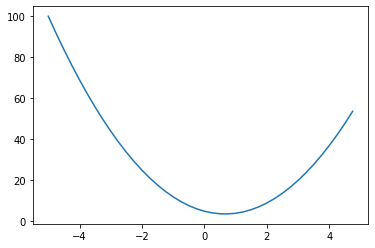

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.00001
x = 2/3
(f(x + h) - f(x)) / h

3.0000002482211127e-05

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001
#inputs 

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label 
        
    def __repr__(self):
        return f"value(data={self.data}"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out 
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

value(data=-8.0

In [10]:
a = Value(2.0)
b = Value(4.0)
a - b 

value(data=-2.0

In [11]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular {'record'} node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid +  n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

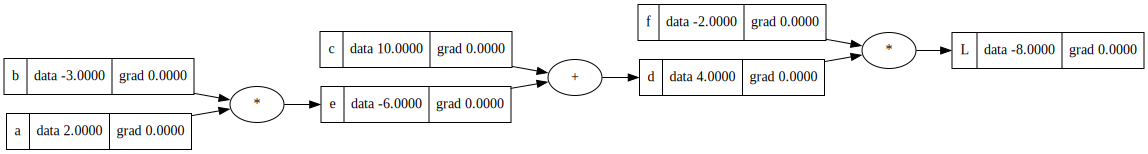

In [12]:
draw_dot(L)



In [13]:
L

value(data=-8.0

In [14]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
b.grad = -4
a.grad = 6

In [15]:
dot = draw_dot(L)
dot.render(filename='dot')

'dot.png'

In [16]:
def lol():
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
lol()

6.000000000000227


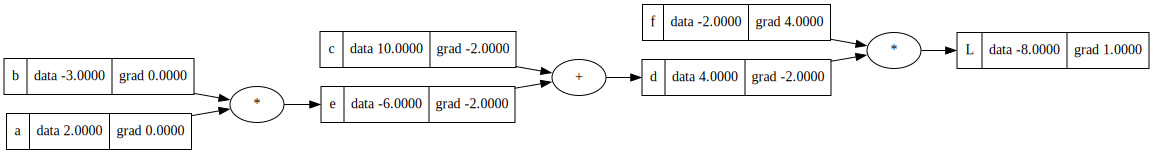

In [17]:
draw_dot(L)

In [18]:
#optimization

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L)

value(data=-35.549696


In [19]:
# this is example of one step of optimization

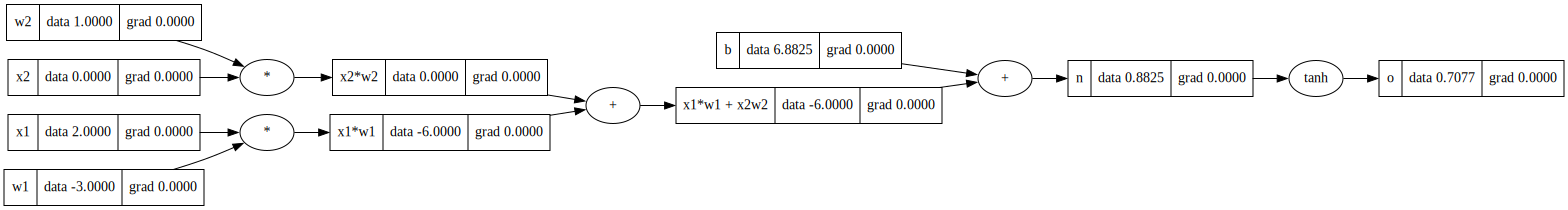

In [20]:
#input 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88247182471, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2w2'
n = x1w1x2w2+b; n.label='n'
o = n.tanh(); o.label='o'
draw_dot(o)


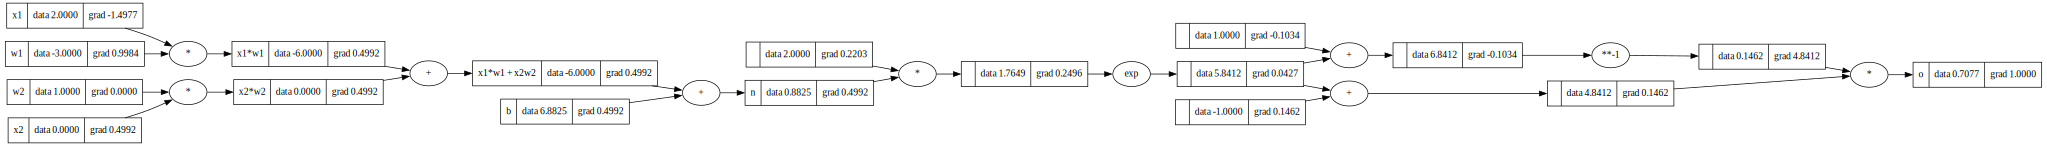

In [28]:
#input 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88247182471, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2w2'
n = x1w1x2w2+b; n.label='n'
#------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#------
o.label = 'o'
o.backward()
draw_dot(o)

In [33]:
import torch

x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True 
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

0.7071050214706146


In [35]:
o.backward()

In [44]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [45]:
print('---')
print('x2: ', x2.grad.item())
print('w2: ', w2.grad.item())
print('x1: ', x1.grad.item())
print('w1: ', w1.grad.item())

---
x2:  0.5000024886110417
w2:  0.0
x1:  -1.500007465833125
w1:  1.0000049772220834


0.5000024886110417

In [49]:
import random

In [98]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

value(data=0.8594583454985946

In [116]:
w = [Value(random.uniform(-1,1)) for _ in range(5)]
w

[value(data=0.2239574096265624,
 value(data=-0.894535070500067,
 value(data=0.025135127366363363,
 value(data=0.6517628675742029,
 value(data=0.007728021176224953]

In [121]:
w = [0.1, 0.2, 0.3, 0.4, 0.5]
x = [1, 2, 3, 4, 5]
for wi, xi in zip(w, x):
    print(wi, xi)

0.1 1
0.2 2
0.3 3
0.4 4
0.5 5


In [ ]:
act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)


In [126]:
b = 0.5

In [127]:
c = sum([wi * xi for wi, xi in zip(w, x)], b)

In [128]:
c 

6.0